In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Load the Dataset from Google Drive

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Replace "file_id" with the ID of your file.
file_id = "1viikPAeGpINr79z9e8qj7SryyYqWkBr4"
file = drive.CreateFile({'id': file_id})

# Download the file.
try:
    file.GetContentFile(file['title'])
except:
    print("Error downloading file.")
!unzip Facemask.zip. 

unzip:  cannot find or open Facemask.zip., Facemask.zip..zip or Facemask.zip..ZIP.


## Data Preprocessing

#### Data Loading: 
Create a tensorflow dataset directory for training and Validation

In [ ]:
path_to_zip = "Face Mask Dataset"
PATH = os.path.join(os.path.dirname(path_to_zip), "Face Mask Dataset")

train_dir = os.path.join(PATH, 'Train')
validation_dir = os.path.join(PATH, 'Validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 10000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 800 files belonging to 2 classes.


Show the first nine images and labels from the training set:

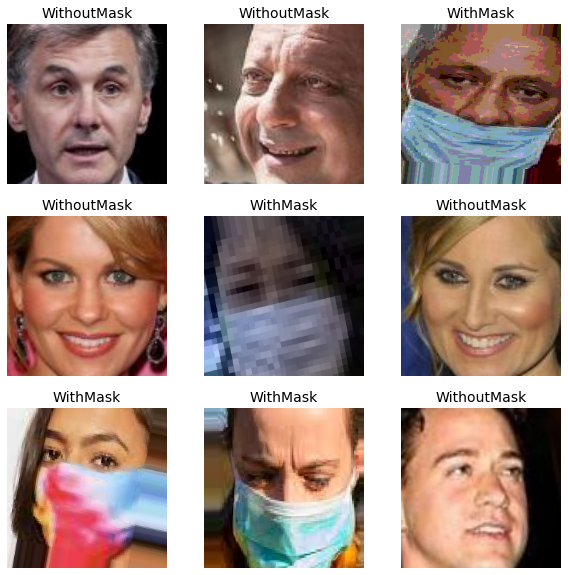

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Creating testing dataset. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 16
Number of test batches: 4


#### Configure the dataset for performance

Using buffered prefetching to load images from disk without having I/O become blocking

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#### Use data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

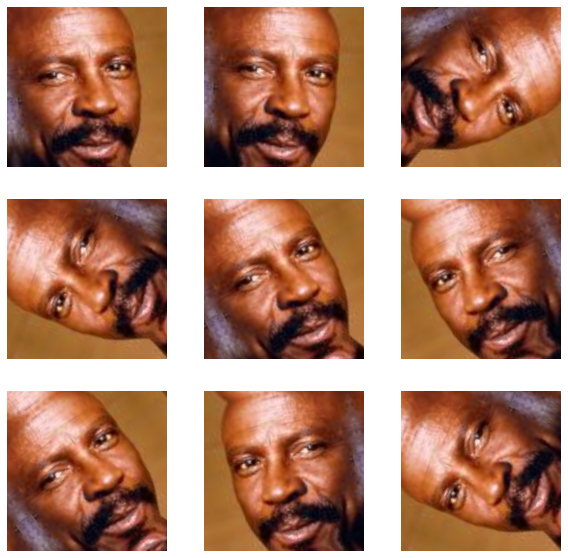

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescale pixel values
We are using tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Create the base model from the pre-trained convnets

We will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify mask and NoMask from our specific dataset.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


it is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them

In [ ]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

## Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

## Train the model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

16/16 [==============================] - 15s 697ms/step - loss: 0.8842 - accuracy: 0.3730


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.88
initial accuracy: 0.37


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


313/313 [==============================] - 299s 925ms/step - loss: 0.4238 - accuracy: 0.7998 - val_loss: 0.1529 - val_accuracy: 0.9688
Epoch 2/10
313/313 [==============================] - 241s 769ms/step - loss: 0.1561 - accuracy: 0.9504 - val_loss: 0.0837 - val_accuracy: 0.9844
Epoch 3/10
313/313 [==============================] - 263s 839ms/step - loss: 0.1035 - accuracy: 0.9708 - val_loss: 0.0642 - val_accuracy: 0.9922
Epoch 4/10
313/313 [==============================] - 243s 775ms/step - loss: 0.0804 - accuracy: 0.9767 - val_loss: 0.0486 - val_accuracy: 0.9961
Epoch 5/10
313/313 [==============================] - 242s 771ms/step - loss: 0.0698 - accuracy: 0.9764 - val_loss: 0.0394 - val_accuracy: 0.9961
Epoch 6/10
313/313 [==============================] - 240s 767ms/step - loss: 0.0656 - accuracy: 0.9794 - val_loss: 0.0362 - val_accuracy: 0.9961
Epoch 7/10
313/313 [==============================] - 236s 754ms/step - loss: 0.0577 - accuracy: 0.9818 - val_loss: 0.0278 - val_accura

## Learning curves
Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNetV2 base model as a fixed feature extractor

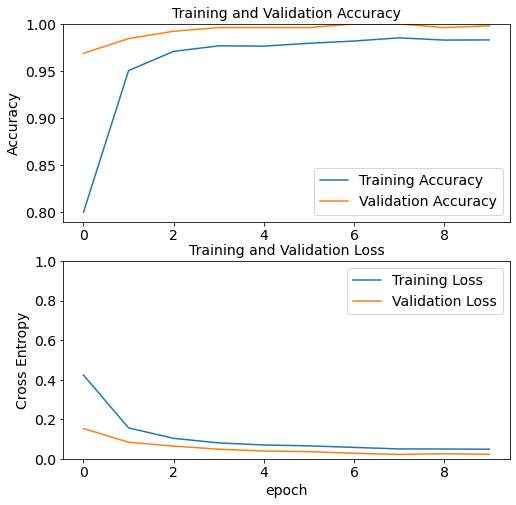

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 [==============================] - 3s 551ms/step - loss: 0.0185 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1]
Labels:
 [1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 1]


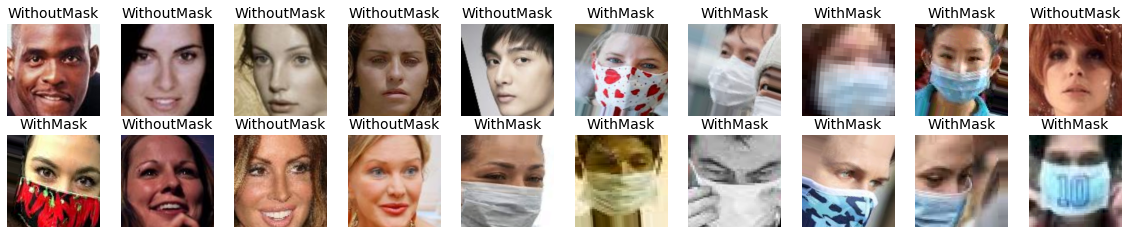

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(20, 20))
for i in range(20):
      ax = plt.subplot(10, 10, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(class_names[predictions[i]])
      plt.axis("off")

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predictions, label_batch)
print(cm)

[[15  0]
 [ 0 17]]
